In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, RidgeCV, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, mean_squared_error
from modelling_functions_new import *

## Processing for Models

In [123]:
#### Read Data files
dict_dictonary = {}
housing, housing_features, feat_labels = read_and_clean(filepath = "../data/clean_train.csv")
htest_id, htest_features, htest_labels = read_and_clean(filepath = "../data/clean_test.csv", test = True)
training = housing_features
testing = htest_features

#### Process and Generate Train Test Splits
test_col = testing.columns
train_col = training.columns

missing = [x for x in train_col if x not in test_col]
needed = [x for x in test_col if x not in train_col]

training = training.drop(missing, axis=1)
testing = testing.drop(needed, axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(training, housing.saleprice, test_size = 0.2, random_state=42)

In [124]:
def plot_model_accuracy(df):
    fig, ax1 = plt.subplots()    
    #ax1.plot(df.index, df['Train Score'],label = 'Train Score')
    ax1.plot(df.index, df['Test Score'],label='Test Score')
    ax1.set_xlabel('Model')
    plt.xticks(rotation=40)
    ax1.set_ylabel('R2')
    
    ax2 = ax1.twinx()
    ax2.plot(df.index, df['Kaggle Metric'], label = 'Kaggle Score',color='blue')
    ax2.set_ylabel('RMSLE')
    plt.title('Model Fitness on Test Set')
    plt.legend(loc=1)
    plt.show()
    
def rmsle(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: #check for negative values
            continue
        p = (predicted[x]+1)
        r = (real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

Tuning Hyperparameters...
Best Alpha Found: 9e-05

Running Lasso Regression for Feature Selection...
Dropping 55 columns

Training Models ...


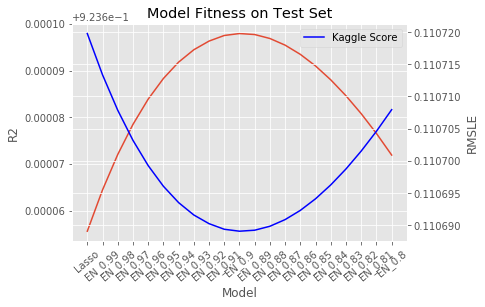

Best Model:  EN_0.9
Kaggle Score:  0.1107



In [125]:
# Train each linear model on the train test splits
from sklearn import linear_model as lm
import sklearn.model_selection as ms
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.simplefilter('ignore')

## Split Training / Testing Data
X_train, X_test, Y_train, Y_test = train_test_split(training, housing.saleprice, test_size = 0.2, random_state=42)

## Build the Model Set
alpha_steps = (1e-5,1e-2,200)
steps = np.linspace(1,0.8,21)
lasso = lm.Lasso()
ridge = lm.Ridge()
elasticnets = [lm.ElasticNet(l1_ratio = i) for i in steps[1:]]
names = ['Lasso'] + ['EN_' + str(round(i,2)) for i in steps[1:]]
modelList = pd.Series([lasso] + elasticnets, index = names)

## Hyperparameter Tuning
print('Tuning Hyperparameters...')
param_grid = {'max_iter': [10,100,1000],
            'alpha':np.linspace(1e-5,9e-5,10)}
grid = ms.GridSearchCV(modelList.Lasso,param_grid,scoring='r2',cv=10)
grid.fit(X_train, Y_train)
best_alpha = grid.best_params_['alpha']
best_iter = grid.best_params_['max_iter']
print('Best Alpha Found: {}\n'.format(best_alpha))
modelList.apply(lambda x: x.set_params(alpha = best_alpha, max_iter = best_iter))

## Feature Selection
print("Running Lasso Regression for Feature Selection...")
modelList.Lasso.fit(X_train, Y_train)
drop_col = list(training.columns[np.where(modelList.Lasso.coef_ == 0)[0]])
print("Dropping {} columns\n".format(len(drop_col)))
X_train = X_train.drop(drop_col, axis = 1)
X_test = X_test.drop(drop_col, axis = 1)

## Running on train set
print('Training Models ...')
modelList.apply(lambda x: x.fit(X_train, Y_train))
train_errors, test_errors = [], []
train_errors.append(modelList.apply(lambda x: x.score(X_train, Y_train)))
test_errors.append(modelList.apply(lambda x: x.score(X_test, Y_test)))
scores_df = pd.DataFrame({"Train Score":modelList.apply(lambda x: x.score(X_train, Y_train)),
                         "Test Score": modelList.apply(lambda x: x.score(X_test, Y_test)),
                         "Kaggle Metric": modelList.apply(lambda x: rmsle(Y_test.values, x.predict(X_test)))
                        })

plot_model_accuracy(scores_df)
np.argmin(scores_df['Kaggle Metric'])
print('Best Model: ', np.argmin(scores_df['Kaggle Metric']))
print('Kaggle Score: ', round(min(scores_df['Kaggle Metric']),4))

## 
print('')
modelList[np.argmin(scores_df['Kaggle Metric'])].fit(training, housing.saleprice)
pred = np.exp(modelList[np.argmin(scores_df['Kaggle Metric'])].predict(testing))
#Submission(htest_id, pred)

## Lasso

In [122]:
scores_df

,Train Score,Test Score,Kaggle Metric
Lasso,0.937420,0.914673,0.117053
EN_0.99,0.937428,0.914660,0.117061
EN_0.98,0.937437,0.914648,0.117069
EN_0.97,0.937445,0.914636,0.117078
EN_0.96,0.937454,0.914623,0.117086
EN_0.95,0.937462,0.914610,0.117095
EN_0.94,0.937470,0.914598,0.117104
EN_0.93,0.937478,0.914585,0.117113
EN_0.92,0.937486,0.914572,0.117121
EN_0.91,0.937494,0.914559,0.117130


(1452, 214)

In [ ]:
alp = optimize_penalty(htrain, ptrain, model=Lasso, min_=1e-4, max_=10, step=0.0001, plot=True)

In [ ]:
lasso = Lasso(normalize=False)
lasso.set_params(alpha = 3e-4)
lasso.fit(htrain, ptrain)

print(lasso.score(htrain, ptrain))
print(lasso.score(htest, ptest))
#print(selected_coefs)
pred_lasso = lasso.predict(htest)
mean_squared_error(pred_lasso, ptest)

In [ ]:
pred = np.exp(lasso.predict(testing))

In [ ]:
Submission(htest_id, pred, "lasso.csv")

In [ ]:
drop_col = list(training.columns[np.where(lasso.coef_ == 0)[0]])
print(drop_col)

In [ ]:
training = training.drop(drop_col, axis = 1)
testing = testing.drop(drop_col, axis = 1)

In [ ]:
print(training.shape)
print(testing.shape)

In [ ]:
htrain, htest, ptrain, ptest = train_test_split(training, housing.saleprice, test_size = 0.2, random_state = 480)

## RandomForestRegressor

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 10000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [15, 20, 30, 40]
# Minimum number of samples required at each leaf node
min_samples_leaf = [16, 32, 64]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = -1)
# Fit the random search model
rf_random.fit(htrain, ptrain)

In [ ]:
rf_random.best_params_

In [ ]:
#rf_random.fit(htrain, ptrain)

print(rf_random.score(htrain, ptrain))
pred_rf_random = rf_random.predict(htest)
mean_squared_error(pred_rf_random, ptest)

In [ ]:
clf = RandomForestRegressor(n_estimators=10000, 
                            random_state=9, 
                            n_jobs=-1, 
                            min_samples_split = 40, 
                            min_samples_leaf = 1, 
                            max_features = 'sqrt', 
                            max_depth = 162,
                            bootstrap = True)
#sfm = SelectFromModel(clf, threshold = 0.01)
#sfm.fit(htrain, ptrain)
# ## Not Finished
# # Measure Feature Importance
#feature_selected = []
#for feature_list_index in sfm.get_support(indices=True):
#     feature_selected.append(feat_labels[feature_list_index])
#proxy = feature_selected
#trimmed = ['x1stflrsf', 'x2ndflrsf', 'garagecars', 'overallcond', 'saleprice', 'Unnamed: 0', 'bsmtfinsf1']
#testing = testing[proxy]
#housing_features = housing_features[trimmed_features]
#print(feature_selected)

In [ ]:
clf.fit(htrain, ptrain)

clf.score(htest, ptest)

In [ ]:
pred_clf = clf.predict(htest)
mean_squared_error(pred_clf, ptest)

## ElasticNet

In [ ]:
regr = ElasticNetCV(l1_ratio = [.1, .2, .3, .4, .5, .6, .7, .8, .9, .99, 1], 
                    cv = 5, 
                    n_jobs = -1,
                    normalize = True,
                    verbose = 0)

In [ ]:
regr.fit(htrain, ptrain)

In [ ]:
regr.score(htest, ptest)
pred_regr = regr.predict(htest)
mean_squared_error(pred_regr, ptest)

In [ ]:
regr.l1_ratio_

### Ridge

In [ ]:
ridge = RidgeCV(normalize = True, cv = 5)

ridge.fit(htrain, ptrain)

In [ ]:
print(ridge.score(htest, ptest))
pred_ridge = ridge.predict(htest)
mean_squared_error(pred_ridge, ptest)

In [ ]:
t = pd.read_csv('submission_13703.csv')

In [ ]:
lm = LinearRegression(normalize = True)
lm.fit(htrain, ptrain)
print(lm.score(htest, ptest))
pred_linear = lm.predict(htest)
mean_squared_error(pred_linear, ptest)

In [ ]:
a = 0.1
b = 0.3
c = 0.5
d = 0.1

pred_ridge_sub = ridge.predict(testing)
pred_lasso_sub = lasso.predict(testing)
pred_linear_sub = lm.predict(testing)
pred_regr_sub = regr.predict(testing)
#pred_rf_random_sub = rf_random.predict(testing)

pred_sum = np.exp(a*(pred_ridge_sub) + b*(pred_lasso_sub) + c*(pred_regr_sub) + d*(pred_linear_sub))

Submission(htest_id, pred_sum, "stacked_submission.csv")

In [ ]:
ridge.predict(testing)

In [ ]:
pred_sum.shape

In [ ]:
a = 0.1
b = 0.3
c = 0.5
d = 0.1



pred_sum = a*(pred_ridge) + b*(pred_lasso) + c*(pred_regr) + d*(pred_linear)
mean_squared_error(pred_sum, ptest)

In [ ]:
pred_sum = (pred_ridge + pred_lasso + pred_regr + pred_linear)/4
mean_squared_error(pred_sum, ptest)

In [ ]:
mean_squared_error(pred_sum, ptest)

## Kernal Ridge

In [ ]:
from sklearn.kernel_ridge import KernelRidge

ker = KernelRidge(alpha = 40)
ker.fit(htrain, ptrain)

In [ ]:
print(ker.score(htest, ptest))
pred_ker = ker.predict(htest)
mean_squared_error(pred_ker, ptest)

## Linear Model

In [ ]:
lm = LinearRegression(normalize = True, n_jobs = -1)

In [ ]:
training = housing_features.drop(housing_features.columns[drop_col], axis=1)
testing = htest_features.drop(housing_features.columns[drop_col], axis=1)

In [ ]:
print(training.shape)
print(testing.shape)

In [ ]:
htrain, htest, ptrain, ptest = train_test_split(training, housing.saleprice, test_size = 0.33, random_state = 0)

In [ ]:
lm.fit(htrain, ptrain)

lm.score(htest, ptest)

In [ ]:
lm.sample_

In [ ]:
pred = lm.predict(htest)
mean_squared_error(pred, ptest)

In [ ]:
pred = np.exp(lm.predict(testing))
print(pred[1:3])
Submission(htest_id, pred)